## Environment

In [15]:
import numpy as np
from sklearn import datasets, decomposition, cluster, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

In [2]:
# Set plotting settings
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

## Loading data

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/x-atlas-consortia/hra-pop/main/output-data/v0.10.2/reports/atlas/validation-v5.csv")
data.head()

,sex,consortium_name,dataset,tool,modality,reported_organ,organ,organId,rui_location_volume,cell_id,cell_label,cell_count,percentage
0,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002063,AT2,760,0.145678
1,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002062,AT1,733,0.140502
2,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,ASCTB-TEMP:non-classical-monocytes,Non-classical monocytes,571,0.109450
3,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,CL:0002144,EC general capillary,523,0.100249
4,Female,NHLBI/LungMap,https://api.cellxgene.cziscience.com/dp/v1/col...,azimuth,sc_transcriptomics,http://purl.obolibrary.org/obo/UBERON_0002048,respiratory system,UBERON:0001004,75,ASCTB-TEMP:monocyte-derived-m,Monocyte-derived Mφ,508,0.097374


## Cleaning up strings and setting categorical variables

First, we process the text data in the 'organ' variable to remove extraneous words.

In [4]:
data.organ = data.organ.str.replace("left ","", regex=True)
data.organ = data.organ.str.replace("right ","", regex=True)
data.organ = data.organ.str.replace("Set of lactiferous glands in breast","mammary gland", regex=True)
data.organ = data.organ.str.replace("respiratory system", "lung", regex=True)
data.organ = data.organ.str.replace("male reproductive system","prostate", regex=True)
data.organ = data.organ.str.replace(" of body","", regex=True)
data.organ = data.organ.str.title()

Next, we set variable data types.

In [5]:
data.organ = data.organ.astype("category")
data['organCode'] = data['organ'].cat.codes
data.organId = data.organId.astype("category")
data.reported_organ = data.reported_organ.astype("category")
data.consortium_name = data.consortium_name.astype("category")
data['consCode'] = data['consortium_name'].cat.codes
data.dataset = data.dataset.astype("category")
data.modality = data.modality.astype("category")
data.cell_id = data.cell_id.astype("category")
data.cell_label = data.cell_label.astype("category")

Finally, we remove spatial proteomics data sets from the analysis.

## Aggregating Data for Cell Type Analysis Tools
In this section we implement pivot table to reshape the cell type counts measurements for each dataset, based on the cell type analysis tool applied to the dataset. The analysis is limited to the tools: Azimuth, CellTypist and PopV. SC Proteomics data is excluded.

In [6]:
data = data.drop(data[data['modality'] == 'sc_proteomics'].index)

#### Azimuth

In [7]:
data_az = data[data['tool'].isin({'azimuth'})]
data_az_cellperc = data_az.pivot_table(index=['dataset','organ','tool'],
                                       columns='cell_id',
                                       values='cell_count',
                                       aggfunc='mean',
                                       fill_value='0',
                                       observed=True,
                                       margins=False)
data_az_cellperc.shape

(365, 93)

#### CellTypist

In [8]:
data_ct = data[data['tool'].isin({'celltypist'})]
data_ct_cellperc = data_ct.pivot_table(index=['dataset','organ','tool'],
                                       columns='cell_id',
                                       values='cell_count',
                                       aggfunc='mean',
                                       fill_value='0',
                                       observed=True,
                                       margins=False)
data_ct_cellperc.shape

(237, 232)

#### PopV

In [9]:
data_pv = data[data['tool'].isin({'popv'})]
data_pv_cellperc = data_pv.pivot_table(index=['dataset','organ','tool'],
                                               columns='cell_id',
                                               values='cell_count',
                                               aggfunc='mean',
                                               fill_value='0',
                                               observed=True,
                                               margins=False)
data_pv_cellperc.shape

(269, 88)

Note that the number of cell type (93 columns) identified in by the *azimuth* tool is smaller than the number of cell types identified by *popv* and *celltypist* tools (233 columns).

## Applying PCA Analysis

A significant challeng to generating UMAP plots is the extensive number of cell types identified across the three cell analysis tools. To help reduce the number of features, PCA analysis is applied to each data set. PCA results for each tool are reviewed to identify the set of dimensions that capture cumulative variance betwen 70-80%.

#### Azimuth

In [39]:
# Define PCA model
pca_az = decomposition.PCA(n_components=10, svd_solver='full', copy=True, whiten=True)

# Fit PCA model
pca_az.fit(data_az_cellperc)

# Number of components estitimated
print(pca_az.n_components_)
ncomp = pca_az.n_components_

# Explanation of variance
print(round(sum(pca_az.explained_variance_ratio_) * 100,2))
cumsum_var = round(sum(pca_az.explained_variance_ratio_) * 100,2)

# Set output and add results to 
pca_az.set_output(transform="pandas")
data_az_cellperc_pca = pca_az.transform(data_az_cellperc)

10
93.41


#### CellTypist

In [40]:
# Define PCA model
pca_ct = decomposition.PCA(n_components=10, svd_solver='full', copy=True, whiten=True)

# Fit PCA model
pca_ct.fit(data_ct_cellperc)

# Number of components estitimated
print(pca_ct.n_components_)
ncomp = pca_ct.n_components_

# Explanation of variance
print(round(sum(pca_ct.explained_variance_ratio_) * 100,2))
cumsum_var = round(sum(pca_ct.explained_variance_ratio_) * 100,2)

# Set output and add results to 
pca_ct.set_output(transform="pandas")
data_ct_cellperc_pca = pca_ct.transform(data_ct_cellperc)

10
99.3


#### PopV

In [41]:
# Define PCA model
pca_pv = decomposition.PCA(n_components=10, svd_solver='full', copy=True, whiten=True)

# Fit PCA model
pca_pv.fit(data_pv_cellperc)

# Number of components estitimated
print(pca_pv.n_components_)
ncomp = pca_pv.n_components_

# Explanation of variance
print(round(sum(pca_pv.explained_variance_ratio_) * 100,2))
cumsum_var = round(sum(pca_pv.explained_variance_ratio_) * 100,2)

# Set output and add results to 
pca_pv.set_output(transform="pandas")
data_pv_cellperc_pca = pca_pv.transform(data_pv_cellperc)

10
95.2


In [42]:
#data_az_cellperc_pca.shape
#data_ct_cellperc_pca.shape
#data_pv_cellperc_pca.shape

## UMAP Analysis

### UMAP Settings 
The UMAP reducers for all of the UMAPS will use the same hyperparameters setting: 
* Metric = *Euclidean Distance*
* Neighbors = 50
* Minimum distance is set to .1

#### UMAP Azimuth Tools
This UMAP analysis processes all data sets that used the Azimuth tool for cell type identification.

In [43]:
reducer2 = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding_a = reducer2.fit_transform(data_az_cellperc_pca)

In [44]:
# Adds in Organ data to embeddings
data_cellperc_az = data_az[['dataset','organ']].drop_duplicates()
data_cellperc_az = data_cellperc_az.reset_index()
data_organs_a = pd.concat([data_cellperc_az, pd.DataFrame(embedding_a, columns=['0','1'])], axis=1)

Text(0.0, 1.0, 'Azimuth')

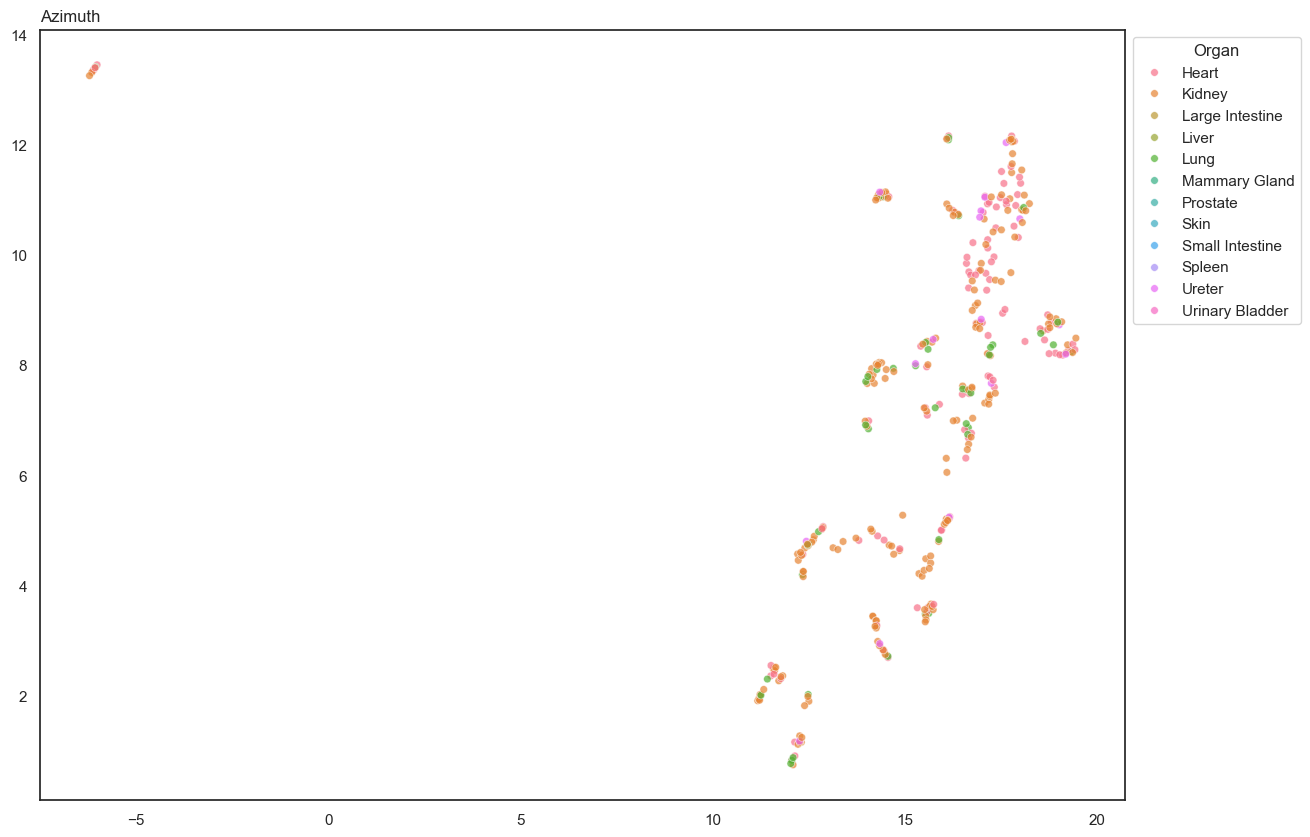

In [45]:
#Plot
sns.scatterplot(x = embedding_a[:, 0], 
                y = embedding_a[:, 1], s=30,
                hue=data_organs_a.organ,
                alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.title('Azimuth', loc='left', fontsize=12)

#### UMAP Cell Typist

In [46]:
reducer3 = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding_c = reducer3.fit_transform(data_ct_cellperc_pca)

In [47]:
# Adds in Organ data to embeddings
data_cellperc_ct = data_ct[['dataset','organ']].drop_duplicates()
data_cellperc_ct = data_cellperc_ct.reset_index()
data_organs_c = pd.concat([data_cellperc_ct, pd.DataFrame(embedding_c, columns=['0','1'])], axis=1)

Text(0.0, 1.0, 'Cell Typist')

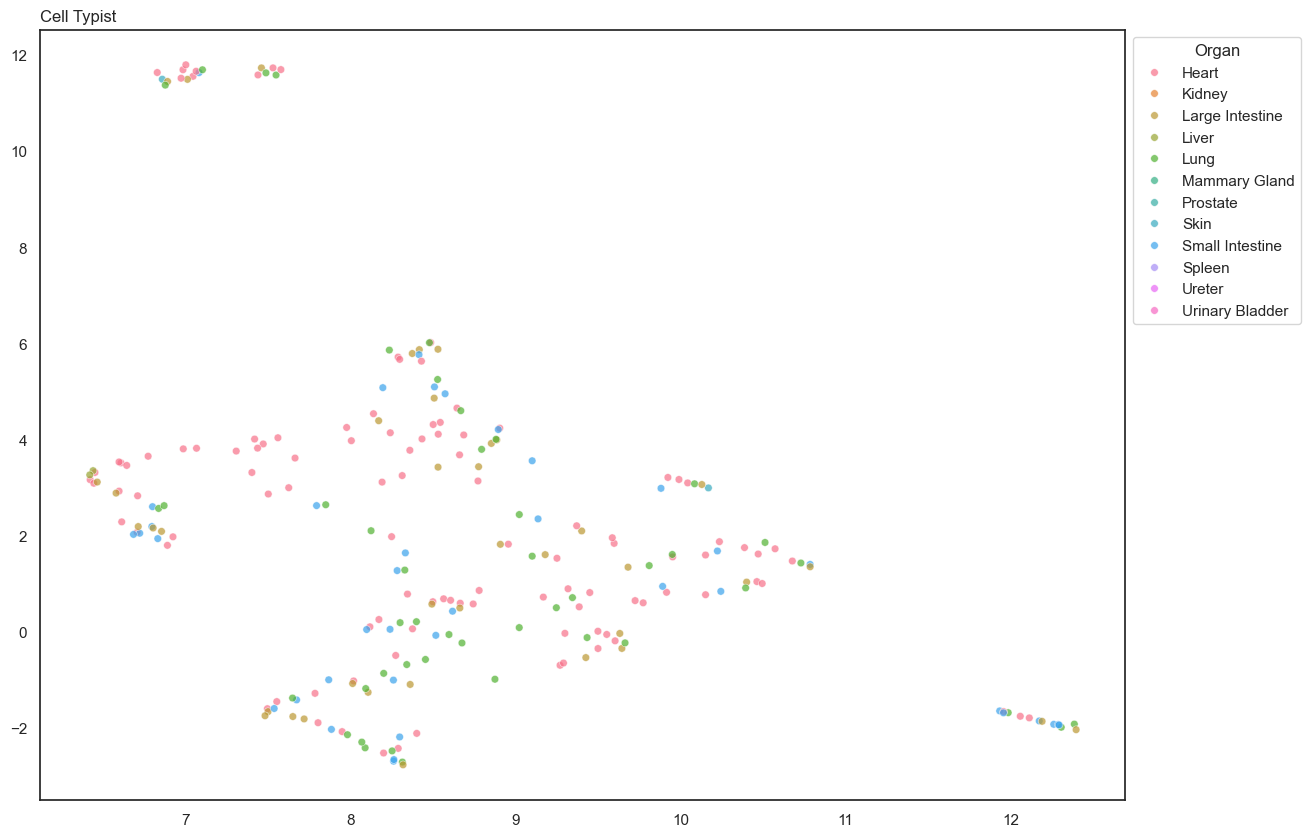

In [48]:
sns.scatterplot(x = embedding_c[:, 0], 
                y = embedding_c[:, 1], s=30,
                hue=data_organs_c.organ,
                alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.title('Cell Typist', loc='left', fontsize=12)

#### UMAP Pop V

In [49]:
reducer4 = umap.UMAP(n_neighbors=50, min_dist=.1, n_components=2, metric='euclidean')
embedding_p = reducer4.fit_transform(data_pv_cellperc_pca)

In [50]:
# Adds in Organ data to embeddings
data_cellperc_pv = data_pv[['dataset','organ']].drop_duplicates()
data_cellperc_pv = data_cellperc_pv.reset_index()
data_organs_p = pd.concat([data_cellperc_pv, pd.DataFrame(embedding_p, columns=['0','1'])], axis=1)

Text(0.0, 1.0, 'Pop V Tool')

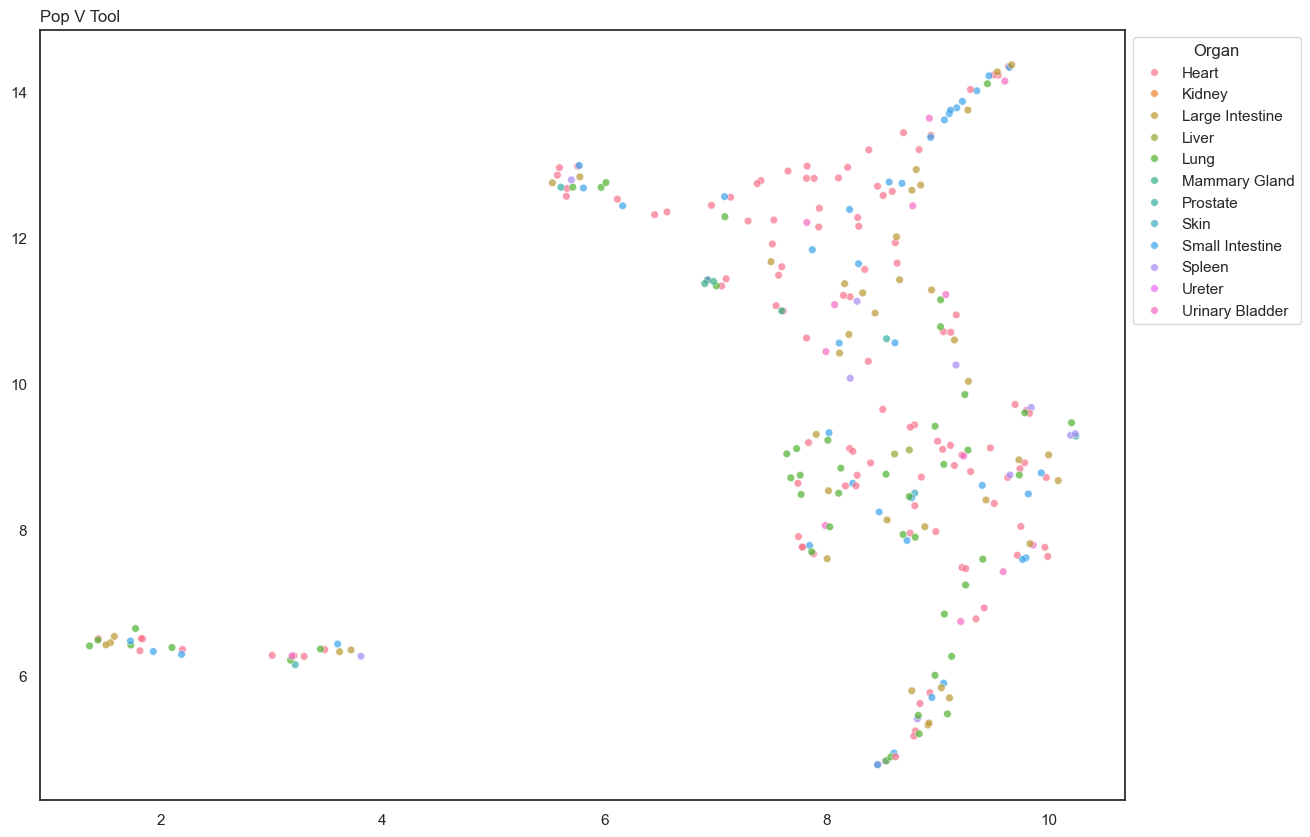

In [51]:
sns.scatterplot(x = embedding_p[:, 0], 
                y = embedding_p[:, 1], s=30,
                hue=data_organs_p.organ,
                alpha=0.7)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), title="Organ")
plt.title('Pop V Tool', loc='left', fontsize=12)